## **[Monte Carlo Cross-Validation for Time Series](https://towardsdatascience.com/monte-carlo-cross-validation-for-time-series-ed01c41e2995)**
### How to get better forecasting performance estimates with a bit of randomness

Applying cross-validation to time series requires attention to a few key aspects. These points are important to prevent leakage and get reliable performance estimates.

Here, you’ll learn about Monte Carlo cross-validation. An alternative method to the popular TimeSeriesSplits approach.

#### **Time Series Cross-Validation**
TimeSeriesSplit is usually the preferred method for cross-validation with time series data. Figure 1 illustrates how this method operates. The available time series is split into several folds with equal sizes. Then, each fold is first used to test a model and then to re-train it. Except for the first fold, which is only used for training.

<center> <p>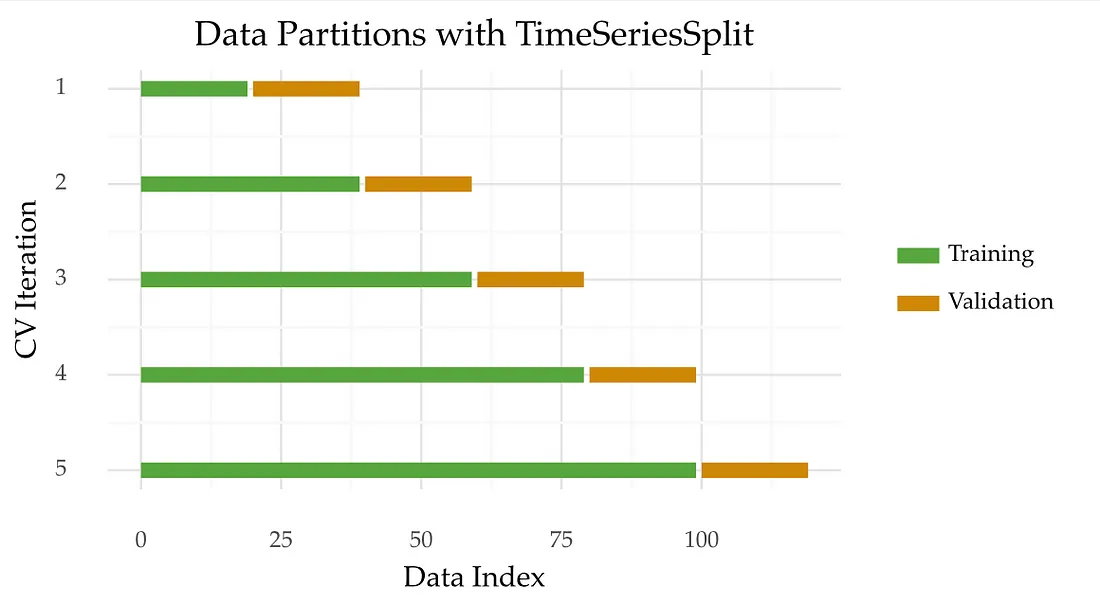</p> </center>

The main benefits of using TimeSeriesSplit for cross-validation are the following:

1. It preserves the order of observations. This issue is important in ordered data sets such as time series.
2. It creates many splits. Several splits lead to more robust performance estimates. This point is especially important if the data set is not large.

The main downside of TimeSeriesSplit is the training sample size inconsistency across folds.

What does this mean?

Suppose that the method is applied with 5 folds like in Figure 1. In the first iteration, 20% of all available observations are used for training. But, this number is 80% for the last iteration. So, the initial iterations may not be representative of the complete time series. This problem can compromise the performance estimates.

How can you solve this issue?

### **Monte Carlo Cross-Validation**
Monte Carlo cross-validation (MonteCarloCV) is a method that can be used for time series. The idea is to repeat the typical holdout cycle at different **random** starting points.

Here’s a visual description of this approach:

<center> <p>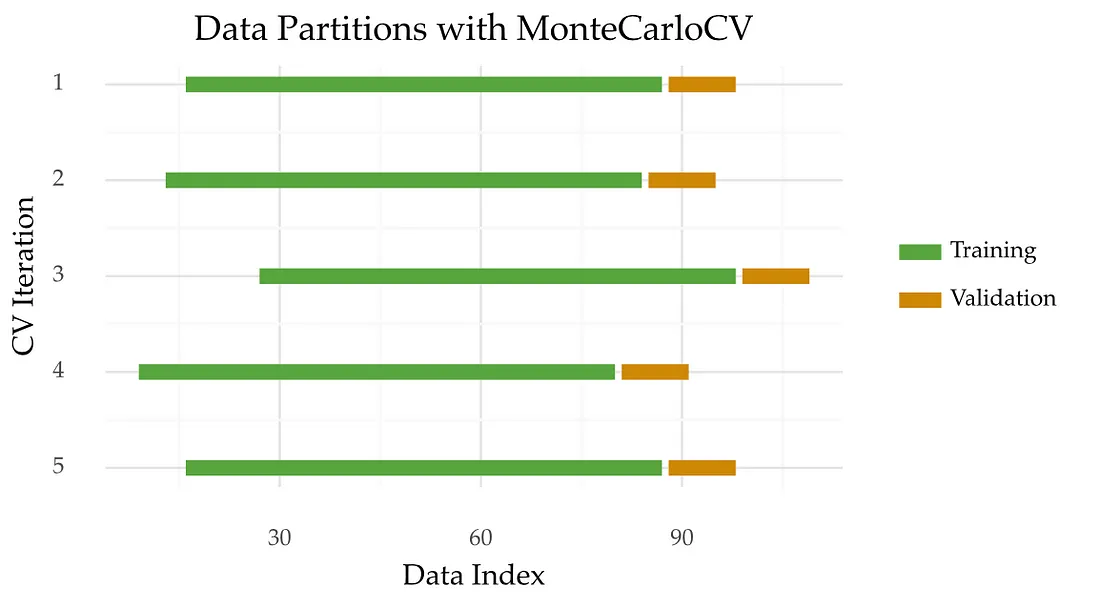</p> </center>

Like TimeSeriesSplit, MonteCarloCV also preserves the temporal order of observations. It also repeats the estimation process several times.

There are two main aspects that distinguish MonteCarloCV from TimeSeriesSplit:

- **Training and validation sample sizes.** As explained above, the training set size grows when using TimeSeriesSplit. In MonteCarloCV, the training set size is fixed at each iteration of the procedure. This prevents training sizes that are not representative of the whole data;
- **Random partitions.** In MonteCarloCV, the validation origin is selected at random. This origin is the point that marks the end of the training set and the start of validation. In the case of TimeSeriesSplit, this point is deterministic. It is pre-defined according to the number of iterations.
MonteCarloCV was first used by Picard and Cook. You can check reference [1] for details.

I’ve studied MonteCarloCV during my Ph.D with some detail. This included a comparison with other methods such as TimeSeriesSplit. One of my goals was to understand which approach provides the best estimates. The conclusions pointed to MonteCarloCV, so I’ve been using it ever since. You can check the complete study in reference [2].

Unfortunately, `scikit-learn` does not provide an implementation for MonteCarloCV. So, I decided to do it myself:

In [3]:
import sys
sys.path.insert(0, '../')

from typing import List, Generator

import numpy as np

from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import indexable, _num_samples


class MonteCarloCV(_BaseKFold):

    def __init__(self,
                n_splits: int,
                train_size: float,
                test_size: float,
                gap: int = 0):
        """
        Monte Carlo Cross-Validation

        Holdout applied in multiple testing periods
        Testing origin (time-step where testing begins) is randomly chosen according to a monte carlo simulation

        :param n_splits: (int) Number of monte carlo repetitions in the procedure
        :param train_size: (float) Train size, in terms of ratio of the total length of the series
        :param test_size: (float) Test size, in terms of ratio of the total length of the series
        :param gap: (int) Number of samples to exclude from the end of each train set before the test set.
        """

        self.n_splits = n_splits
        self.n_samples = -1
        self.gap = gap
        self.train_size = train_size
        self.test_size = test_size
        self.train_n_samples = 0
        self.test_n_samples = 0

        self.mc_origins = []

    def split(self, X, y=None, groups=None) -> Generator:
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """

        X, y, groups = indexable(X, y, groups)
        self.n_samples = _num_samples(X)

        self.train_n_samples = int(self.n_samples * self.train_size) - 1
        self.test_n_samples = int(self.n_samples * self.test_size) - 1

        # Make sure we have enough samples for the given split parameters
        if self.n_splits > self.n_samples:
            raise ValueError(
                f'Cannot have number of folds={self.n_splits} greater'
                f' than the number of samples={self.n_samples}.'
            )
        if self.train_n_samples - self.gap <= 0:
            raise ValueError(
                f'The gap={self.gap} is too big for number of training samples'
                f'={self.train_n_samples} with testing samples={self.test_n_samples} and gap={self.gap}.'
            )

        indices = np.arange(self.n_samples)

        selection_range = np.arange(self.train_n_samples + 1, self.n_samples - self.test_n_samples - 1)

        self.mc_origins = \
            np.random.choice(a=selection_range,
                            size=self.n_splits,
                            replace=True)

        for origin in self.mc_origins:
            if self.gap > 0:
                train_end = origin - self.gap + 1
            else:
                train_end = origin - self.gap
            train_start = origin - self.train_n_samples - 1

            test_end = origin + self.test_n_samples

            yield (
                indices[train_start:train_end],
                indices[origin:test_end],
            )

    def get_origins(self) -> List[int]:
        return self.mc_origins

#### *Practical Example*
MonteCarloCV takes four parameters:

- n_splits: The number of folds or iterations. This value tends to be up to 10;
- training_size: Size of the training set at each iteration as the ratio of the size of the time series;
- test_size: Like training_size, but for the validation set;
- gap: The number of observations separating the training and validation sets. Like in TimeSeriesSplits, the value of this parameter defaults to 0 (no gap).

The train and validation size for each iteration depends on the input data. I’ve found a 0.6/0.1 partition to work well. That is, at each iteration 60% of the data is used for training. The following 10% observations are used for validation.

Here’s an example with the configuration above:

In [4]:
from sklearn.datasets import make_regression
from src.mccv import MonteCarloCV

X, y = make_regression(n_samples=120)

mccv = MonteCarloCV(n_splits=5, 
                    train_size=0.6, 
                    test_size=0.1, 
                    gap=0)

for train_index, test_index in mccv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101] TEST: [102 103 104 105 106 107 108 109 110 111 112]
TRAIN: [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] TEST: [100 101 102 103 104 105 106 107 108 109 110]
TRAIN: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86] TEST: [87 88 89 90 91 92 93 94 95 96 97]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33

The implementation is also compatible with scikit-learn. Here’s how to combine it with _GridSearchCV_:

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
param_search = {'n_estimators': [10, 100]}

gsearch = GridSearchCV(estimator=model, cv=mccv, param_grid=param_search)
gsearch.fit(X, y)

GridSearchCV(cv=MonteCarloCV(gap=0, n_splits=5, test_size=0.1, train_size=0.6),
             estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 100]})

I hope you find MonteCarloCV useful!

Thanks for reading and see you in the next story.